setup/ import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2 as cv
import tensorflow as tf

from sklearn.model_selection import train_test_split

load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_iphone = pd.read_pickle('/content/drive/MyDrive/Arlette/Dataframes Machine Learning/df_ml.pkl')

In [ ]:
df_without_iphone = pd.read_pickle('/content/drive/MyDrive/Arlette/Dataframes Machine Learning/df_without_iphone_ml.pkl')

In [ ]:
print(df_iphone.columns)
print(df_without_iphone.columns)

Index(['File Name clean', 'Genus', 'LABEL', 'processed_image', 'x1', 'x2',
       'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13',
       'x14', 'x15', 'x16', 'x17', 'x18', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6',
       'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16',
       'y17', 'y18'],
      dtype='object')
Index(['File Name clean', 'Genus', 'LABEL', 'processed_image', 'x1', 'x2',
       'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13',
       'x14', 'x15', 'x16', 'x17', 'x18', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6',
       'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16',
       'y17', 'y18'],
      dtype='object')


The original dataframes both contain landmarks in normalized pixel range [0,1] and integer images (0-255) in original format (320, 640, 3)

define landmarks and images for both dataframes

1) resize images for dataframe including all pictures

In [ ]:
#images
X = np.stack(df_iphone["processed_image"].values) #(n, 320, 640)

#resize images
X_resized = tf.image.resize(X, (160,320)).numpy()

#transform to uint8
X_resized = np.clip(X_resized, 0, 255).astype(np.uint8)

In [ ]:
X_resized.shape

(4935, 160, 320, 3)

In [ ]:
X_resized.dtype

dtype('uint8')

2) resize images for wo iphone dataframe

In [1]:
#images
X_wo = np.stack(df_without_iphone["processed_image"].values) # (n, 320, 640)

#resize images
X_wo_resized = tf.image.resize(X_wo, (160,320)).numpy()

#transform to uint8
X_wo_resized = np.clip(X_wo_resized, 0, 255).astype(np.uint8)

NameError: name 'np' is not defined

In [ ]:
X_wo_resized.dtype

dtype('uint8')

In [ ]:
X_wo_resized.shape

(4322, 160, 320, 3)

1.2 dataframe including all pictures

In [ ]:
#get x and y coordinates from df
x_cols = [f"x{i}" for i in range(1, 19)]
y_cols = [f"y{i}" for i in range(1, 19)]

x_coords = df_iphone[x_cols].to_numpy().astype(np.float32)  # (n, 18)
y_coords = df_iphone[y_cols].to_numpy().astype(np.float32)

#landmarks (combine x and y to shape (n, 18, 2))
y_norm = np.stack([x_coords, y_coords], axis=-1)

#transform landmarks into pixel coordinates
H, W = 160, 320

y_px = y_norm.copy()
y_px[:, :, 0] = y_px[:, :, 0] * W  # x-coordinates
y_px[:, :, 1] = y_px[:, :, 1] * H  # y-coordinates

#get index
indices = df_iphone.index.to_numpy()

print('X_resized:', X_resized.shape)
print('y normalized:', y_norm.shape)
print('y pixel:', y_px.shape)

X_resized: (4935, 160, 320, 3)
y normalized: (4935, 18, 2)
y pixel: (4935, 18, 2)


2.2 dataframe including no pictures made with iPhone and attachted lens

In [ ]:
#get x and y coordinates from df
x_cols = [f"x{i}" for i in range(1, 19)]
y_cols = [f"y{i}" for i in range(1, 19)]

x_coords_wo = df_without_iphone[x_cols].to_numpy().astype(np.float32)  # (n, 18)
y_coords_wo = df_without_iphone[y_cols].to_numpy().astype(np.float32)

#landmarks (combine x and y to shape (n, 18, 2))
y_norm_wo = np.stack([x_coords_wo, y_coords_wo], axis=-1)

#transform landmarks into pixel coordinates
H, W = 160, 320

y_px_wo = y_norm_wo.copy()
y_px_wo[:, :, 0] = y_px_wo[:, :, 0] * W  # x-coordinates
y_px_wo[:, :, 1] = y_px_wo[:, :, 1] * H  # y-coordinates

#get index
indices_wo = df_without_iphone.index.to_numpy()

print('X_wo_resized:', X_wo_resized.shape)
print('y normalized:', y_norm_wo.shape)
print('y pixel:', y_px_wo.shape)

X_wo_resized: (4322, 160, 320, 3)
y normalized: (4322, 18, 2)
y pixel: (4322, 18, 2)


plot examples

In [ ]:
def plot_sample(index, X, y, labels=None):
    image = X[index]
    landmark = y[index]  # shape (18, 2)

    plt.figure(figsize=(5, 5))
    plt.imshow(image.astype(np.uint8))
    plt.scatter(landmark[:, 0], landmark[:, 1], c='red', s=10)
    plt.axis('off')

    if labels is not None:
        plt.title(f"{labels[index]}")
    else:
        plt.title(f" {index}")

    plt.show()

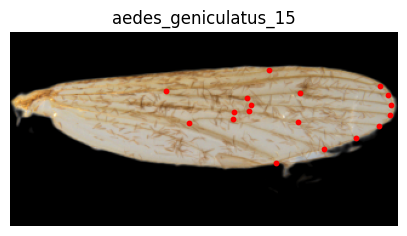

In [ ]:
plot_sample(2356, X_resized, y_px, df_iphone["File Name clean"])

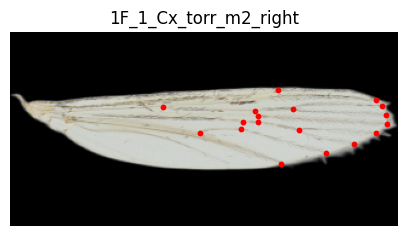

In [ ]:
plot_sample(2356, X_wo_resized, y_px_wo, df_without_iphone["File Name clean"])

train validation test splid

60% train, 20% validation, 20% test

1) splid for dataframe 1

In [ ]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test, idx_temp, idx_test = train_test_split(X_resized, y_px, indices,test_size=0.2,random_state=42,shuffle=True)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(X_temp, y_temp, idx_temp,test_size=0.25,random_state=42,shuffle=True)

print("Train size:", len(X_train))  # 60%
print("Val size:", len(X_val))      # 20%
print("Test size:", len(X_test))    # 20%


Train size: 2961
Val size: 987
Test size: 987


In [ ]:
print(X_train.dtype)

uint8


2) splid for dataframe 2

In [ ]:
X_temp_wo, X_test_wo, y_temp_wo, y_test_wo, idx_temp_wo, idx_test_wo = train_test_split(X_wo_resized, y_px_wo, indices_wo,test_size=0.2,random_state=42,shuffle=True)
X_train_wo, X_val_wo, y_train_wo, y_val_wo, idx_train_wo, idx_val_wo = train_test_split(X_temp_wo, y_temp_wo, idx_temp_wo,test_size=0.25,random_state=42,shuffle=True)

print("Train size:", len(X_train_wo))  # 60%
print("Val size:", len(X_val_wo))      # 20%
print("Test size:", len(X_test_wo))    # 20%

Train size: 2592
Val size: 865
Test size: 865


In [ ]:
print(X_train_wo.dtype)

uint8


full augmenatation using the albumenatations library

In [ ]:
import albumentations as A

augment_pipeline = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=[-0.1, 0.1], contrast_limit=[-0.1, 0.1], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.1),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.2)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


In [ ]:
def augment_data(X, y):
    X_aug = []
    y_aug = []

    for img, keypoints in zip(X, y):
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        augmented = augment_pipeline(image=img, keypoints=keypoints)
        aug_img = augmented["image"]
        aug_kps = np.array(augmented["keypoints"])  # (18, 2)

        X_aug.append(aug_img)
        y_aug.append(aug_kps)

    return np.array(X_aug), np.array(y_aug)

In [ ]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

In [ ]:
X_train_wo_aug, y_train_wo_aug = augment_data(X_train_wo, y_train_wo)

In [ ]:
import numpy as np

print("Min-Wert im Bild:", np.min(X_train_aug))
print("Max-Wert im Bild:", np.max(X_train_aug))
print("Datentyp:", X_train_aug.dtype)

print("Min-Wert im Bild:", np.min(X_val))
print("Max-Wert im Bild:", np.max(X_val))
print("Datentyp:", X_val.dtype)

print("Min-Wert im Bild:", np.min(X_test))
print("Max-Wert im Bild:", np.max(X_test))
print("Datentyp:", X_test.dtype)

Min-Wert im Bild: 0
Max-Wert im Bild: 255
Datentyp: uint8
Min-Wert im Bild: 0
Max-Wert im Bild: 254
Datentyp: uint8
Min-Wert im Bild: 0
Max-Wert im Bild: 254
Datentyp: uint8


In [ ]:
# plots random batch from augmented images, with landmarks
# X_aug: array of the augmented images (n, h, w, 3)
# y_aug: array of landmarks (n, 18, 2)
# batch size: number of plottet images

def plot_augmented_batch(X_aug, y_aug, batch_size=16):
    indices = np.random.choice(len(X_aug), size=batch_size, replace=False)
    n_cols = int(np.ceil(np.sqrt(batch_size)))
    n_rows = int(np.ceil(batch_size / n_cols))

    plt.figure(figsize=(n_cols * 4, n_rows * 4))

    for i, idx in enumerate(indices):
        img = X_aug[idx]
        landmarks = y_aug[idx]

        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img.astype(np.uint8))
        plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

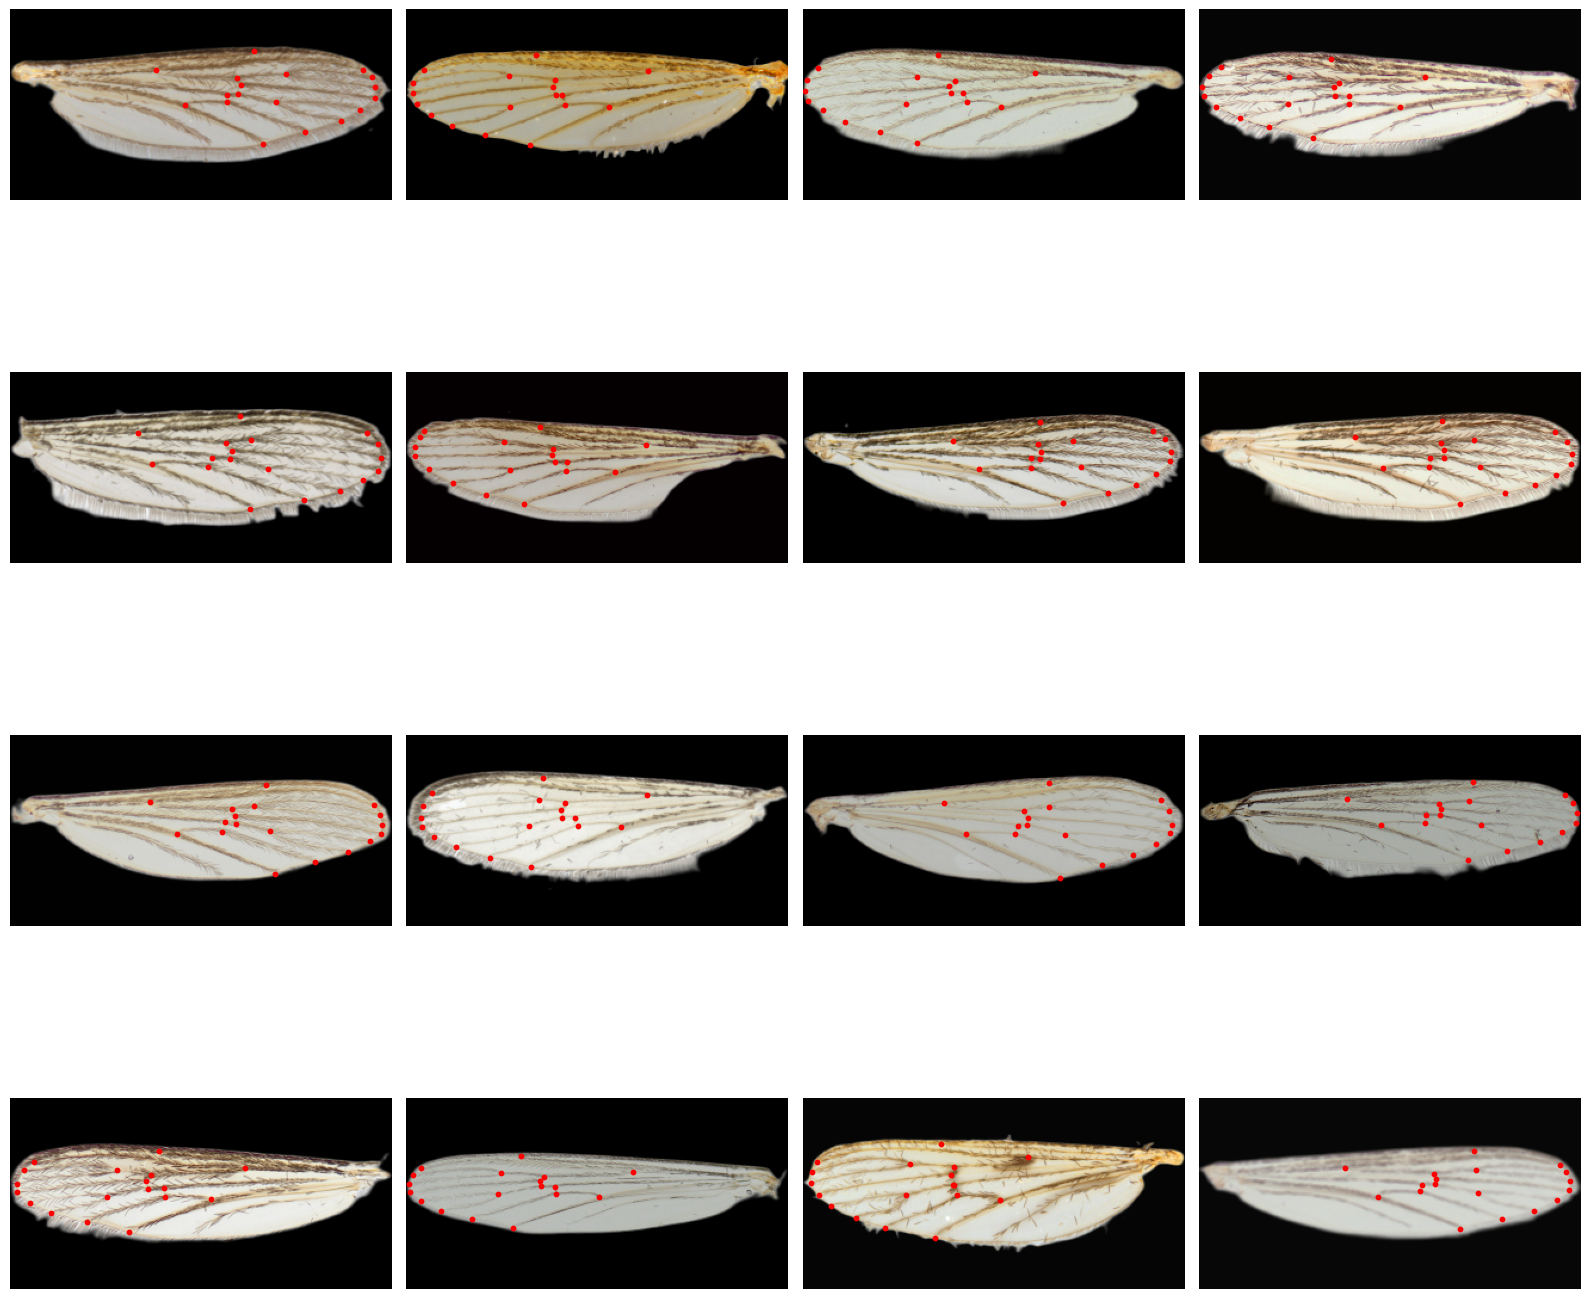

In [ ]:
plot_augmented_batch(X_train_aug, y_train_aug, batch_size=16)

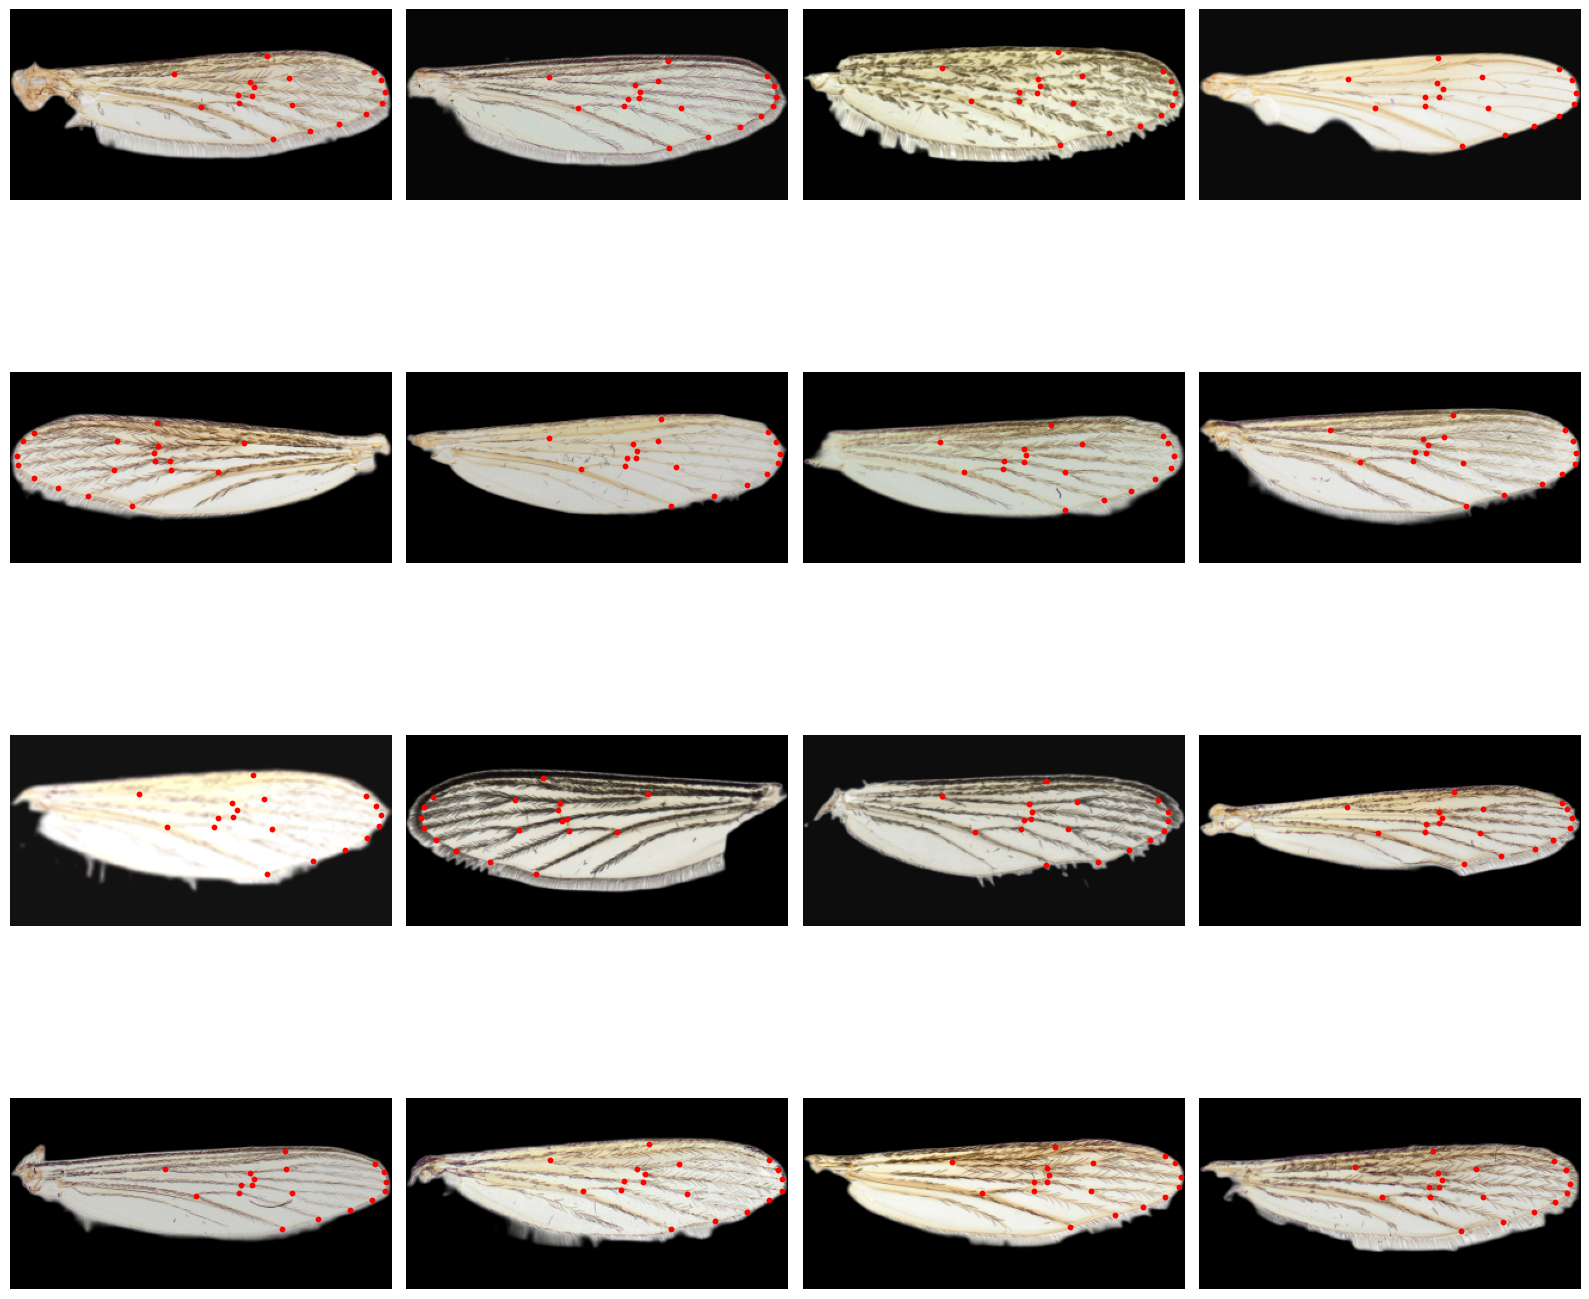

In [ ]:
plot_augmented_batch(X_train_wo_aug, y_train_wo_aug, batch_size=16)

augmenatation using the albumenatations library, excluding blur

In [ ]:
augment_pipeline2 = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=[-0.1, 0.1], contrast_limit=[-0.1, 0.1], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.2)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


In [ ]:
def augment_data_without_blur(X, y):
    X_aug = []
    y_aug = []

    for img, keypoints in zip(X, y):
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        augmented = augment_pipeline2(image=img, keypoints=keypoints)
        aug_img = augmented["image"]
        aug_kps = np.array(augmented["keypoints"])  # (18, 2)

        X_aug.append(aug_img)
        y_aug.append(aug_kps)

    return np.array(X_aug), np.array(y_aug)

In [ ]:
X_train_aug_without_blur, y_train_aug_without_blur = augment_data_without_blur(X_train, y_train)

In [ ]:
X_train_wo_aug_without_blur, y_train_wo_aug_without_blur = augment_data_without_blur(X_train_wo, y_train_wo)

normalize images

In [ ]:
X_train_160x320 = X_train.astype(np.float32)/255.0
X_train_aug_160x320 = X_train_aug.astype(np.float32) / 255.0
X_train_aug_without_blur_160x320 = X_train_aug_without_blur.astype(np.float32) / 255.0
X_val_160x320 = X_val.astype(np.float32) / 255.0
X_test_160x320 = X_test.astype(np.float32) / 255.0

In [ ]:
X_train_wo_160x320 = X_train_wo.astype(np.float32)/255.0
X_train_wo_aug_160x320 = X_train_wo_aug.astype(np.float32) / 255.0
X_train_wo_aug_without_blur_160x320 = X_train_wo_aug_without_blur.astype(np.float32) / 255.0
X_val_wo_160x320 = X_val_wo.astype(np.float32) / 255.0
X_test_wo_160x320 = X_test_wo.astype(np.float32) / 255.0

normalize landmarks

In [ ]:
# normalize
# albumentations required raw pixel data; normalized inputs are generally more practical

In [ ]:
height = 160
width = 320

In [ ]:
y_train_norm = y_train / [width, height]
y_train_aug_norm = y_train_aug / [width, height]
y_train_aug_without_blur_norm = y_train_aug_without_blur / [width, height]
y_val_norm = y_val / [width, height]
y_test_norm = y_test / [width, height]

In [ ]:
y_train_aug_norm.shape

(2961, 18, 2)

In [ ]:
y_train_wo_norm = y_train_wo / [width, height]
y_train_wo_aug_norm = y_train_wo_aug / [width, height]
y_train_wo_aug_without_blur_norm = y_train_wo_aug_without_blur / [width, height]
y_val_wo_norm = y_val_wo / [width, height]
y_test_wo_norm = y_test_wo / [width, height]

create datasets and save

In [ ]:
#datatype_augmentation_imagesize.npy

# datatypes: images/ landmarks/ heatmaps

# augmentation: orig (original), aug (augmented), aug no blur (augmentation excluding blur)
  # no information for validation and test sets. they are always orginal

# imagesize: height x width
  # no information for landmarks, as they are normalized

# percentage of datasets (100/ 50/ 25)
  # if no information, full dataset (100%)

# dataset
  # if no_iPhone, the dataset only includes microscope images, otherwise all data is included

In [ ]:
#with iphone pictures
save_dir = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone'
os.makedirs(save_dir, exist_ok=True)

#Xtrain
np.save(f"{save_dir}/train_orig_images_160x320.npy", X_train_160x320)
#Xtrain aug
np.save(f"{save_dir}/train_aug_images_160x320.npy", X_train_aug_160x320)
#Xtrain aug without blur
np.save(f"{save_dir}/train_aug_images_no_blur_160x320.npy", X_train_aug_without_blur_160x320)
#Xval
np.save(f"{save_dir}/val_images_160x320.npy", X_val_160x320)
#Xtest
np.save(f"{save_dir}/test_images_160x320.npy", X_test_160x320)
#Ytrain
np.save(f"{save_dir}/train_orig_landmarks.npy", y_train_norm)
#Ytrain aug
np.save(f"{save_dir}/train_aug_landmarks.npy", y_train_aug_norm)
#Ytrain aug without blur
np.save(f"{save_dir}/train_aug_landmarks_no_blur.npy", y_train_aug_without_blur_norm)
#Yval
np.save(f"{save_dir}/val_landmarks.npy", y_val_norm)
#Ytest
np.save(f"{save_dir}/test_landmarks.npy", y_test_norm)

In [ ]:
print(X_train_160x320.shape)
print(X_train_aug_160x320.shape)
print(X_train_aug_without_blur_160x320.shape)
print(y_train_norm.shape)
print(y_train_aug_norm.shape)
print(y_train_aug_without_blur_norm.shape)

(2961, 160, 320, 3)
(2961, 160, 320, 3)
(2961, 160, 320, 3)
(2961, 18, 2)
(2961, 18, 2)
(2961, 18, 2)


In [ ]:
#without iphone pictures
save_dir2 = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone'
os.makedirs(save_dir2, exist_ok=True)

#Xtrain
np.save(f"{save_dir2}/train_orig_images_160x320_no_iphone.npy", X_train_wo_160x320)
#Xtrain aug
np.save(f"{save_dir2}/train_aug_images_160x320_no_iphone.npy", X_train_wo_aug_160x320)
#Xtrain aug without blur
np.save(f"{save_dir2}/train_aug_images_no_blur_160x320_no_iphone.npy", X_train_wo_aug_without_blur_160x320)
#Xval
np.save(f"{save_dir2}/val_images_160x320_no_iphone.npy", X_val_wo_160x320)
#Xtest
np.save(f"{save_dir2}/test_images_160x320_no_iphone.npy", X_test_wo_160x320)
#Ytrain
np.save(f"{save_dir2}/train_orig_landmarks_no_iphone.npy", y_train_wo_norm)
#Ytrain aug
np.save(f"{save_dir2}/train_aug_landmarks_no_blur_no_iphone.npy", y_train_wo_aug_without_blur_norm)
#Ytrain aug without blur
np.save(f"{save_dir2}/train_aug_landmarks_no_iphone.npy", y_train_wo_aug_norm)
#Yval
np.save(f"{save_dir2}/val_landmarks_no_iphone.npy", y_val_wo_norm)
#Ytest
np.save(f"{save_dir2}/test_landmarks_no_iphone.npy", y_test_wo_norm)

In [ ]:
print(y_train_norm.shape)
print(y_train_aug_norm.shape)
print(y_train_aug_without_blur_norm.shape)
print(y_val_norm.shape)
print(y_test_norm.shape)
print(y_train_wo_norm.shape)
print(y_train_wo_aug_norm.shape)
print(y_train_wo_aug_without_blur_norm.shape)
print(y_val_wo_norm.shape)
print(y_test_wo_norm.shape)

(2961, 18, 2)
(2961, 18, 2)
(2961, 18, 2)
(987, 18, 2)
(987, 18, 2)
(2592, 18, 2)
(2592, 18, 2)
(2592, 18, 2)
(865, 18, 2)
(865, 18, 2)


save different image sizes

In [ ]:
# upscales all images in X to (320,640)
def upscale_dataset(X, target_size=(320, 640)):
    return np.array([tf.image.resize(img, target_size).numpy().astype(np.uint8) for img in X])

# downscales all images in X to (80,160)
def downscale_dataset(X, target_size=(80, 160)):
    return np.array([tf.image.resize(img, target_size).numpy().astype(np.uint8) for img in X])

In [ ]:
# upscale
X_train_320x640 = upscale_dataset(X_train_160x320)
X_train_aug_320x640 = upscale_dataset(X_train_aug_160x320)
X_train_aug_without_blur_320x640 = upscale_dataset(X_train_aug_without_blur_160x320)
X_val_320x640 = upscale_dataset(X_val_160x320)
X_test_320x640 = upscale_dataset(X_test_160x320)

# downscale
X_train_80x160 = downscale_dataset(X_train_160x320)
X_train_aug_80x160 = downscale_dataset(X_train_aug_160x320)
X_train_aug_without_blur_80x160 = downscale_dataset(X_train_aug_without_blur_160x320)
X_val_80x160 = downscale_dataset(X_val_160x320)
X_test_80x160 = downscale_dataset(X_test_160x320)

In [ ]:
print(X_train_320x640.shape)
print(X_test_80x160.shape)

(2961, 320, 640, 3)
(987, 80, 160, 3)


In [ ]:
#save resized images
#with iphone pictures
save_dir = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone'
os.makedirs(save_dir, exist_ok=True)

#Xtrain
np.save(f"{save_dir}/train_orig_images_320x640.npy", X_train_320x640)
#Xtrain aug
np.save(f"{save_dir}/train_aug_images_320x640.npy", X_train_aug_320x640)
#Xtrain aug without blur
np.save(f"{save_dir}/train_aug_images_no_blur_320x640.npy", X_train_aug_without_blur_320x640)
#Xval
np.save(f"{save_dir}/val_images_320x640.npy", X_val_320x640)
#Xtest
np.save(f"{save_dir}/test_images_320x640.npy", X_test_320x640)

#Xtrain
np.save(f"{save_dir}/train_orig_images_80x160.npy", X_train_80x160)
#Xtrain aug
np.save(f"{save_dir}/train_aug_images_80x160.npy", X_train_aug_80x160)
#Xtrain aug without blur
np.save(f"{save_dir}/train_aug_images_no_blur_80x160.npy", X_train_aug_without_blur_80x160)
#Xval
np.save(f"{save_dir}/val_images_80x160.npy", X_val_80x160)
#Xtest
np.save(f"{save_dir}/test_images_80x160.npy", X_test_80x160)

create different dataset sizes

In [ ]:
# 50% training set
X_train_aug_160x320_50, _, y_train_aug_norm_50, _ = train_test_split(X_train_aug_160x320, y_train_aug_norm, train_size=0.5, random_state=42, shuffle=True)
X_train_aug_no_blur_160x320_50, _, y_train_aug_without_blur_norm_50, _ = train_test_split(X_train_aug_without_blur_160x320, y_train_aug_without_blur_norm, train_size=0.5, random_state=42, shuffle=True)

# 25% training set
X_train_aug_160x320_25, _, y_train_aug_norm_25, _ = train_test_split(X_train_aug_160x320, y_train_aug_norm, train_size=0.25, random_state=42, shuffle=True)
X_train_aug_no_blur_160x320_25, _, y_train_aug_without_blur_norm_25, _ = train_test_split(X_train_aug_without_blur_160x320, y_train_aug_without_blur_norm, train_size=0.25, random_state=42, shuffle=True)

In [ ]:
print(X_train_aug_160x320_50.shape)
print(y_train_aug_norm_50.shape)
print(X_train_aug_no_blur_160x320_50.shape)
print(y_train_aug_without_blur_norm_50.shape)
print(X_train_aug_160x320_25.shape)
print(y_train_aug_norm_25.shape)
print(X_train_aug_no_blur_160x320_25.shape)
print(y_train_aug_without_blur_norm_25.shape)

(1480, 160, 320, 3)
(1480, 18, 2)
(1480, 160, 320, 3)
(1480, 18, 2)
(740, 160, 320, 3)
(740, 18, 2)
(740, 160, 320, 3)
(740, 18, 2)


In [ ]:
#save reduced datasets
#with iphone pictures
save_dir3 = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/reduced datasets'
os.makedirs(save_dir3, exist_ok=True)

#Xtrain aug
np.save(f"{save_dir3}/train_aug_images_160x320_50.npy", X_train_aug_160x320_50)
#Xtrain aug without blur
np.save(f"{save_dir3}/train_aug_images_no_blur_160x320_50.npy", X_train_aug_no_blur_160x320_50)
#Ytrain aug
np.save(f"{save_dir3}/train_aug_landmarks_50.npy", y_train_aug_norm_50)
#Ytrain aug without blur
np.save(f"{save_dir3}/train_aug_landmarks_no_blur_50.npy", y_train_aug_without_blur_norm_50)

#Xtrain aug
np.save(f"{save_dir3}/train_aug_images_160x320_25.npy", X_train_aug_160x320_25)
#Xtrain aug without blur
np.save(f"{save_dir3}/train_aug_images_no_blur_160x320_25.npy", X_train_aug_no_blur_160x320_25)
#Ytrain aug
np.save(f"{save_dir3}/train_aug_landmarks_25.npy", y_train_aug_norm_25)
#Ytrain aug without blur
np.save(f"{save_dir3}/train_aug_landmarks_no_blur_25.npy", y_train_aug_without_blur_norm_25)


create heatmaps for unets

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
# heatmap function (subpixel)
# creates stacked heatmaps for landmark coordinates
# input:
  # y_coords: np.array (num_samples, num_landmarks, 2); normalized [0,1]
  # heatmap size : tuple [int, int], heatmaps size (H,W)
  # sigma: float, standard deviation for gaussian kernel; in pixel
# output:
  # np.array (num_samples, H, W, num_landmarks), heatmap values in range [0,1]

def generate_heatmaps_subpixel(y_coords, heatmap_size=(40,80), sigma=2.0):
    num_samples, num_landmarks = y_coords.shape[:2]
    H, W = heatmap_size
    heatmaps = np.zeros((num_samples, H, W, num_landmarks), dtype=np.float32)

    # coordinate grid for gaussian
    yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

    for i in range(num_samples):
        for l in range(num_landmarks):
            # normalized coordinates to subpixel coordinates
            x = y_coords[i, l, 0] * (W - 1)
            y = y_coords[i, l, 1] * (H - 1)

            # gaussian for subpixel position
            heatmap = np.exp(-0.5 * ((yy - y)**2 + (xx - x)**2) / sigma**2)

            # max 1
            heatmap /= heatmap.max()

            # save
            heatmaps[i, :, :, l] = heatmap

    return heatmaps

Heatmaps shape: (1, 40, 80, 18)


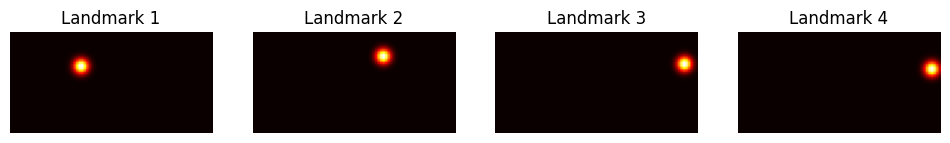

In [ ]:
# plot heatmap exmaple

# choose index
example_idx = 0
example_coords = y_train_norm[example_idx:example_idx+1]

# create heatmap
example_heatmaps = generate_heatmaps_subpixel(example_coords, heatmap_size=(40, 80), sigma=2.0)
print("Heatmaps shape:", example_heatmaps.shape)

# visualiue first 4 landmarks
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(example_heatmaps[0, :, :, i], cmap='hot')
    axes[i].set_title(f'Landmark {i+1}')
    axes[i].axis('off')
plt.show()


save heatmaps

In [ ]:
# heatmap size
heatmap_size = (40, 80)
sigma = 2.0

In [ ]:
# iphone dataset
save_dir = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone'
os.makedirs(save_dir, exist_ok=True)

np.save(f"{save_dir}/train_orig_heatmaps_40x80.npy", generate_heatmaps_subpixel(y_train_norm, heatmap_size, sigma))
np.save(f"{save_dir}/train_aug_heatmaps_40x80.npy", generate_heatmaps_subpixel(y_train_aug_norm, heatmap_size, sigma))
np.save(f"{save_dir}/train_aug_no_blur_heatmaps_40x80.npy", generate_heatmaps_subpixel(y_train_aug_without_blur_norm, heatmap_size, sigma))
np.save(f"{save_dir}/val_heatmaps_40x80.npy", generate_heatmaps_subpixel(y_val_norm, heatmap_size, sigma))
np.save(f"{save_dir}/test_heatmaps_40x80.npy", generate_heatmaps_subpixel(y_test_norm, heatmap_size, sigma))

In [ ]:
# without iphone dataset
save_dir2 = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset without iPhone'
os.makedirs(save_dir2, exist_ok=True)

np.save(f"{save_dir2}/train_orig_heatmaps_40x80_wo_iphone.npy", generate_heatmaps_subpixel(y_train_wo_norm, heatmap_size, sigma))
np.save(f"{save_dir2}/train_aug_heatmaps_40x80_wo_iphone.npy", generate_heatmaps_subpixel(y_train_wo_aug_norm, heatmap_size, sigma))
np.save(f"{save_dir2}/val_heatmaps_40x80_wo_iphone.npy", generate_heatmaps_subpixel(y_val_wo_norm, heatmap_size, sigma))
np.save(f"{save_dir2}/test_heatmaps_40x80_wo_iphone.npy", generate_heatmaps_subpixel(y_test_wo_norm, heatmap_size, sigma))

In [ ]:
# with iPhone reduced dataset
save_dir3 = '/content/drive/MyDrive/Arlette/Sets for Training /Dataset with iPhone/reduced datasets'
os.makedirs(save_dir3, exist_ok=True)

np.save(f"{save_dir}/train_aug_heatmaps_40x80_50.npy", generate_heatmaps_subpixel(y_train_aug_norm_50, heatmap_size, sigma))
np.save(f"{save_dir}/train_aug_no_blur_heatmaps_40x80_50.npy", generate_heatmaps_subpixel(y_train_aug_without_blur_norm_50, heatmap_size, sigma))
np.save(f"{save_dir}/train_aug_heatmaps_40x80_25.npy", generate_heatmaps_subpixel(y_train_aug_norm_25, heatmap_size, sigma))
np.save(f"{save_dir}/train_aug_no_blur_heatmaps_40x80_25.npy", generate_heatmaps_subpixel(y_train_aug_without_blur_norm_25, heatmap_size, sigma))